In [29]:
using DrWatson; @quickactivate
using CSV, DataFrames, DataFramesMeta
using StatsPlots; gr(label = false, dpi = 500)
using StatsBase, LinearRegression, Measurements
using Countries

## Datasets

### Energy data from OWID

https://github.com/owid/energy-data

In [5]:
energy_data = CSV.read(datadir("owid/energy-data.csv"), DataFrame)
country_codes = [c.alpha3 for c in all_countries()]
@subset!(energy_data, in.(:iso_code, Ref(country_codes)))
@subset!(energy_data, .!ismissing.(:gdp) .& .!ismissing.(:energy_per_capita) .& .!ismissing.(:population))
@transform!(energy_data, :energy = :energy_per_capita .* :population);

### Price of energy from IEA

https://www.oecd-ilibrary.org/energy/data/iea-energy-prices-and-taxes-statistics_eneprice-data-en

In [52]:
price_data = CSV.read(datadir("iea/energy-prices.csv"), DataFrame)
names(price_data)

11-element Vector{String}:
 "IEA_LOCATION"
 "Country"
 "IEA_PRODUCT"
 "Product"
 "INDICES"
 "Indices"
 "TIME"
 "Time"
 "Value"
 "Flag Codes"
 "Flags"

In [6]:
price_data = CSV.read(datadir("iea/energy-prices.csv"), DataFrame)
@subset!(price_data, :Indices .== "Retail", length.(:Time) .== 4, :Product .== "Electricity (MWh)")
@transform!(price_data, :year = parse.(Int, :Time))
@transform!(price_data, :energy_price = :Value ./ 1000)
@transform!(price_data, :country = :Country)
@transform!(price_data, :iso_code = :IEA_LOCATION)
@select!(price_data, :year, :iso_code, :energy_price)

1665×3 DataFrame
  Row │ year   iso_code  energy_price    
      │ Int64  String3   Float64?        
──────┼──────────────────────────────────
    1 │  1978  AUS             0.013
    2 │  1979  AUS             0.0142
    3 │  1980  AUS             0.0157
    4 │  1981  AUS             0.0181
    5 │  1982  AUS             0.0227
    6 │  1983  AUS             0.026
    7 │  1984  AUS             0.0272
    8 │  1985  AUS             0.0293
  ⋮   │   ⋮       ⋮             ⋮
 1659 │  2016  CRI             0.104771
 1660 │  2017  CRI             0.0975598
 1661 │  2018  CRI             0.102641
 1662 │  2019  CRI             0.106881
 1663 │  2020  CRI             0.104836
 1664 │  2021  CRI             0.0927004
 1665 │  2022  CRI       missing         
                        1650 rows omitted

In [12]:
data = innerjoin(energy_data, price_data, on = [:year, :iso_code])
@transform!(data, :energy_cost = :energy_price .* :energy)

1475×132 DataFrame
  Row │ country        year   iso_code  population  gdp         biofuel_cons_c ⋯
      │ String         Int64  String3?  Int64?      Float64?    Float64?       ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ Australia       1978  AUS         14355814  3.12728e11              mi ⋯
    2 │ Australia       1979  AUS         14520529  3.29194e11              mi
    3 │ Australia       1980  AUS         14706329  3.35756e11              mi
    4 │ Australia       1981  AUS         14930055  3.48727e11              mi
    5 │ Australia       1982  AUS         15168446  3.48301e11              mi ⋯
    6 │ Australia       1983  AUS         15383079  3.48354e11              mi
    7 │ Australia       1984  AUS         15579478  3.7238e11               mi
    8 │ Australia       1985  AUS         15785685  3.91229e11              mi
  ⋮   │       ⋮          ⋮       ⋮          ⋮           ⋮                  ⋮   ⋱
 1469 │ United States   2012  USA        316651328  1.58496e13                 ⋯
 1470 │ United States   2013  USA        319375168  1.61084e13
 1471 │ United States   2014  USA        322033952  1.64827e13
 1472 │ United States   2015  USA        324607776  1.69026e13
 1473 │ United States   2016  USA        327210208  1.71626e13                 ⋯
 1474 │ United States   2017  USA        329791232  1.75963e13
 1475 │ United States   2018  USA        332140032  1.81406e13
                                               127 columns and 1460 rows omitted

## The energy cost of GDP

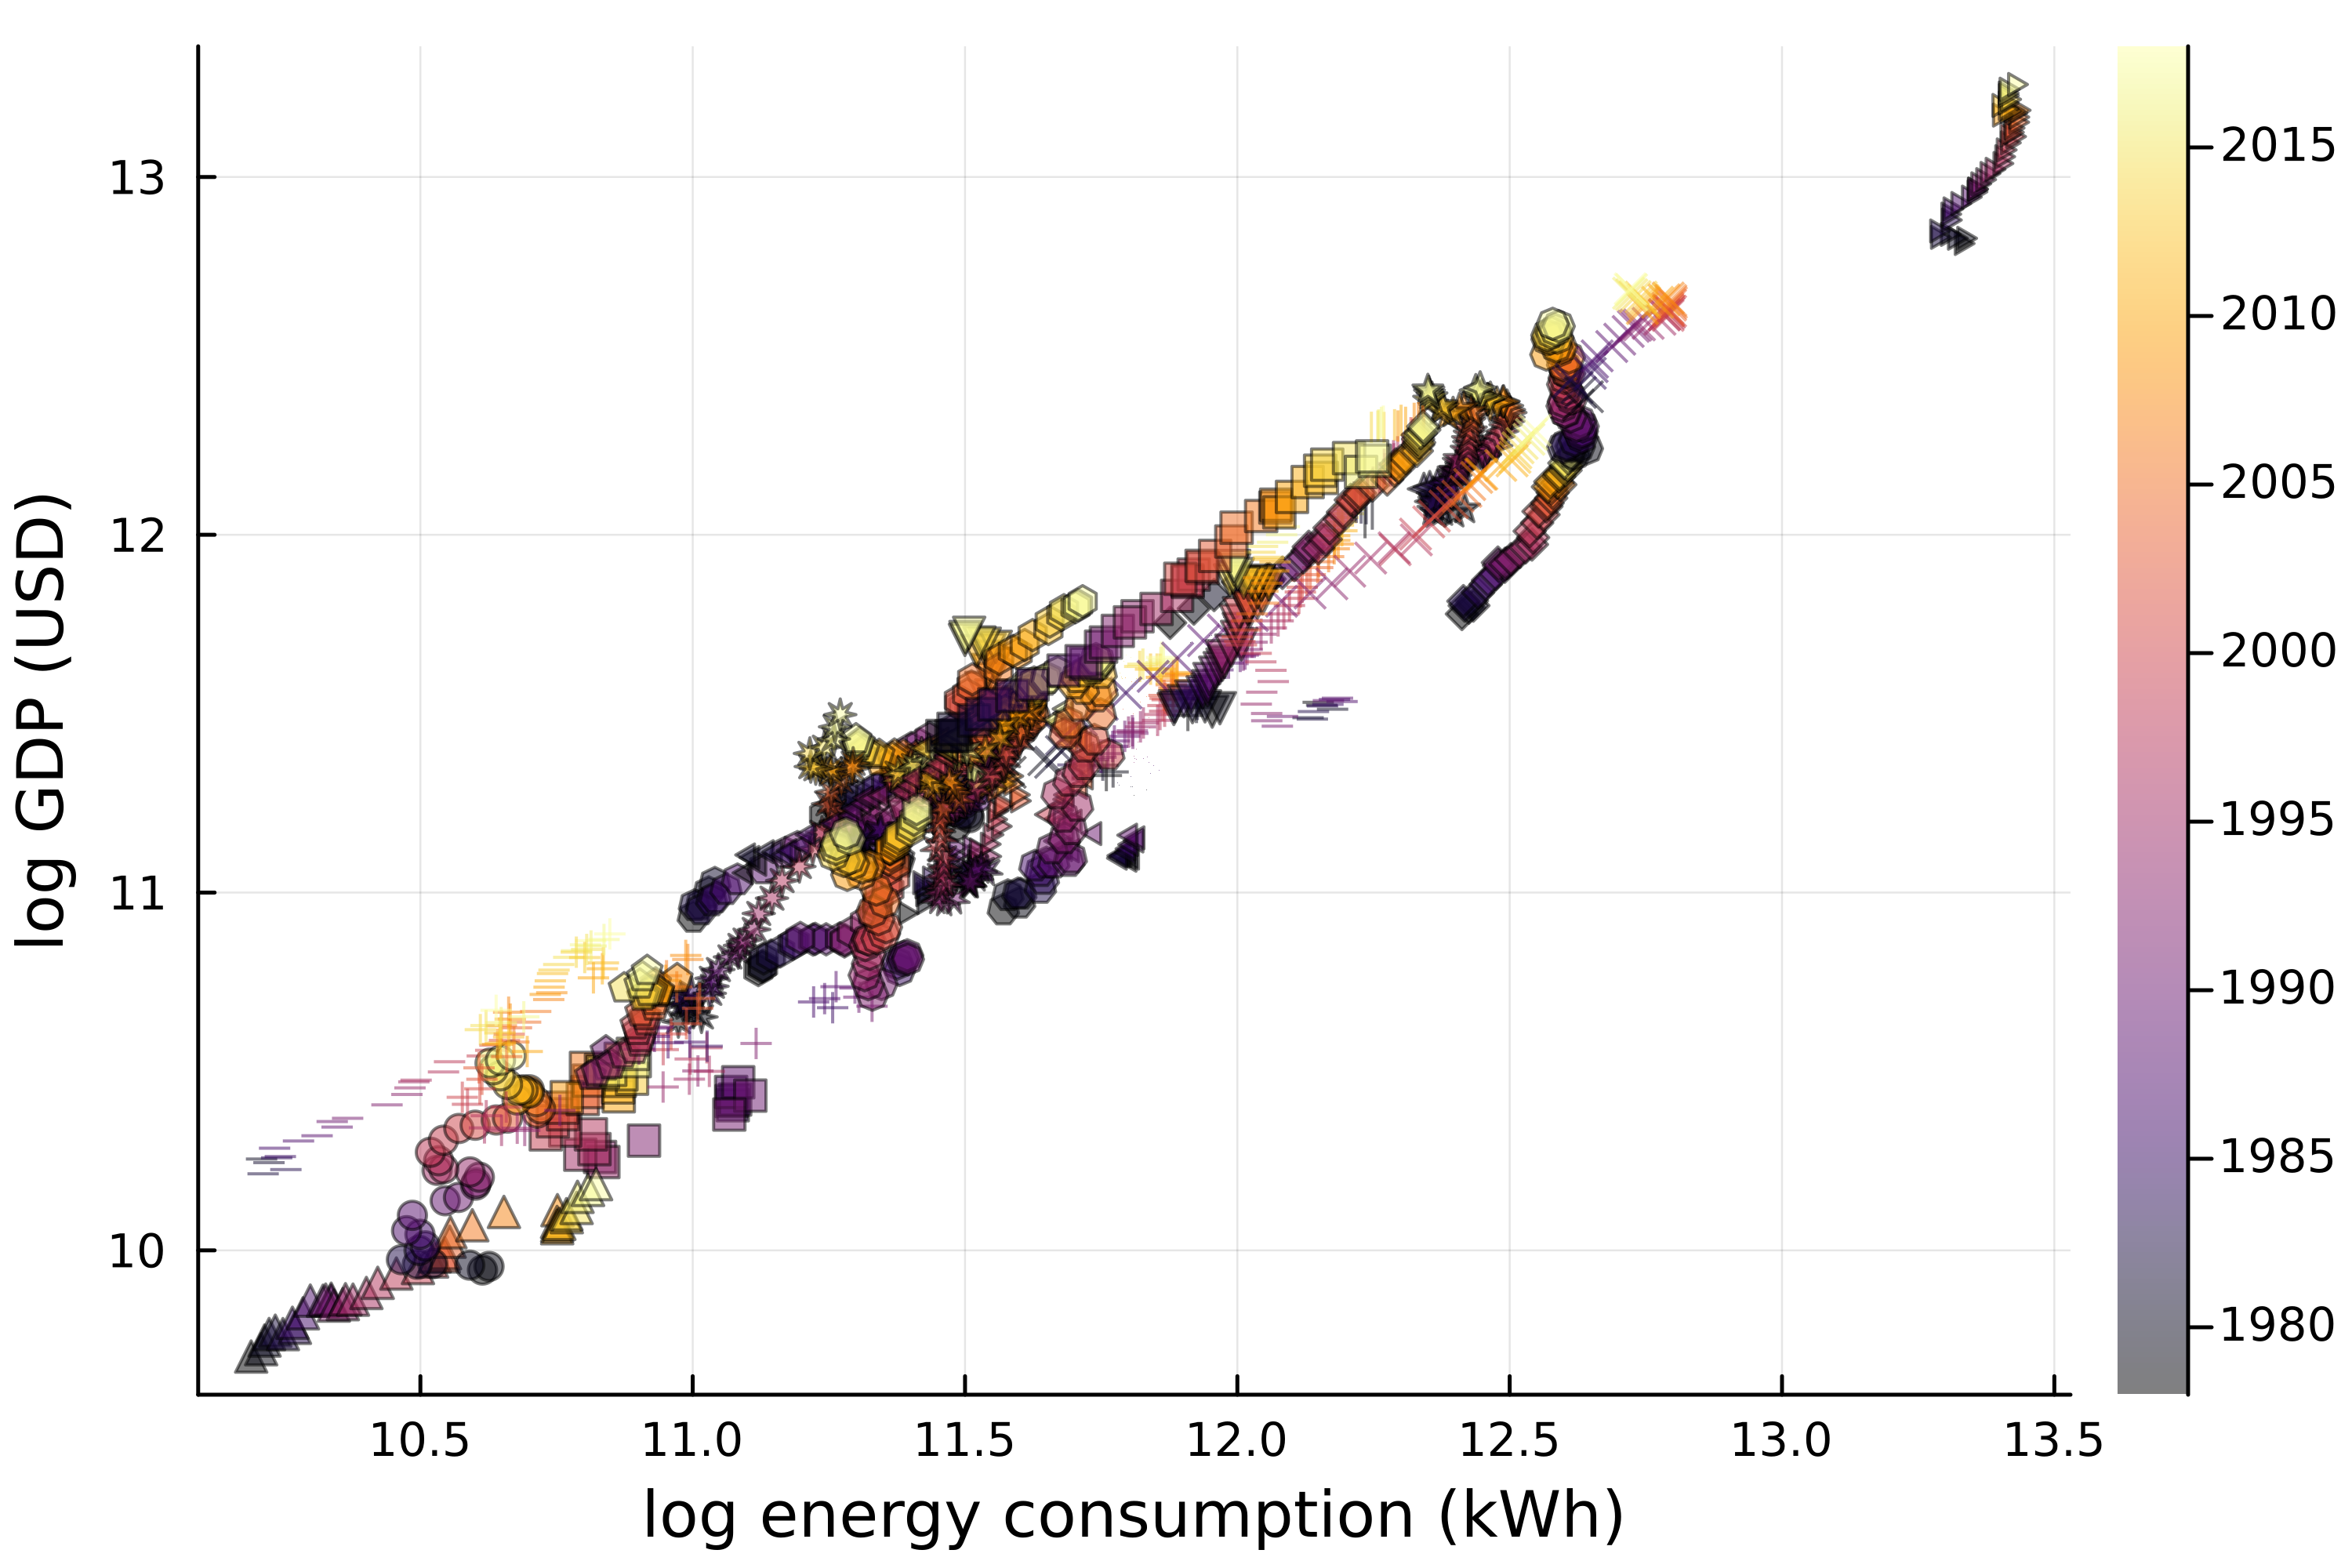

In [40]:
@df data scatter(
    log10.(:energy),
    log10.(:gdp),
    group = :iso_code,
    marker_z = :year,
    label = false,
    xlabel = "log energy consumption (kWh)",
    ylabel = "log GDP (USD)",
    markers = :auto,
    alpha = .5,
    )

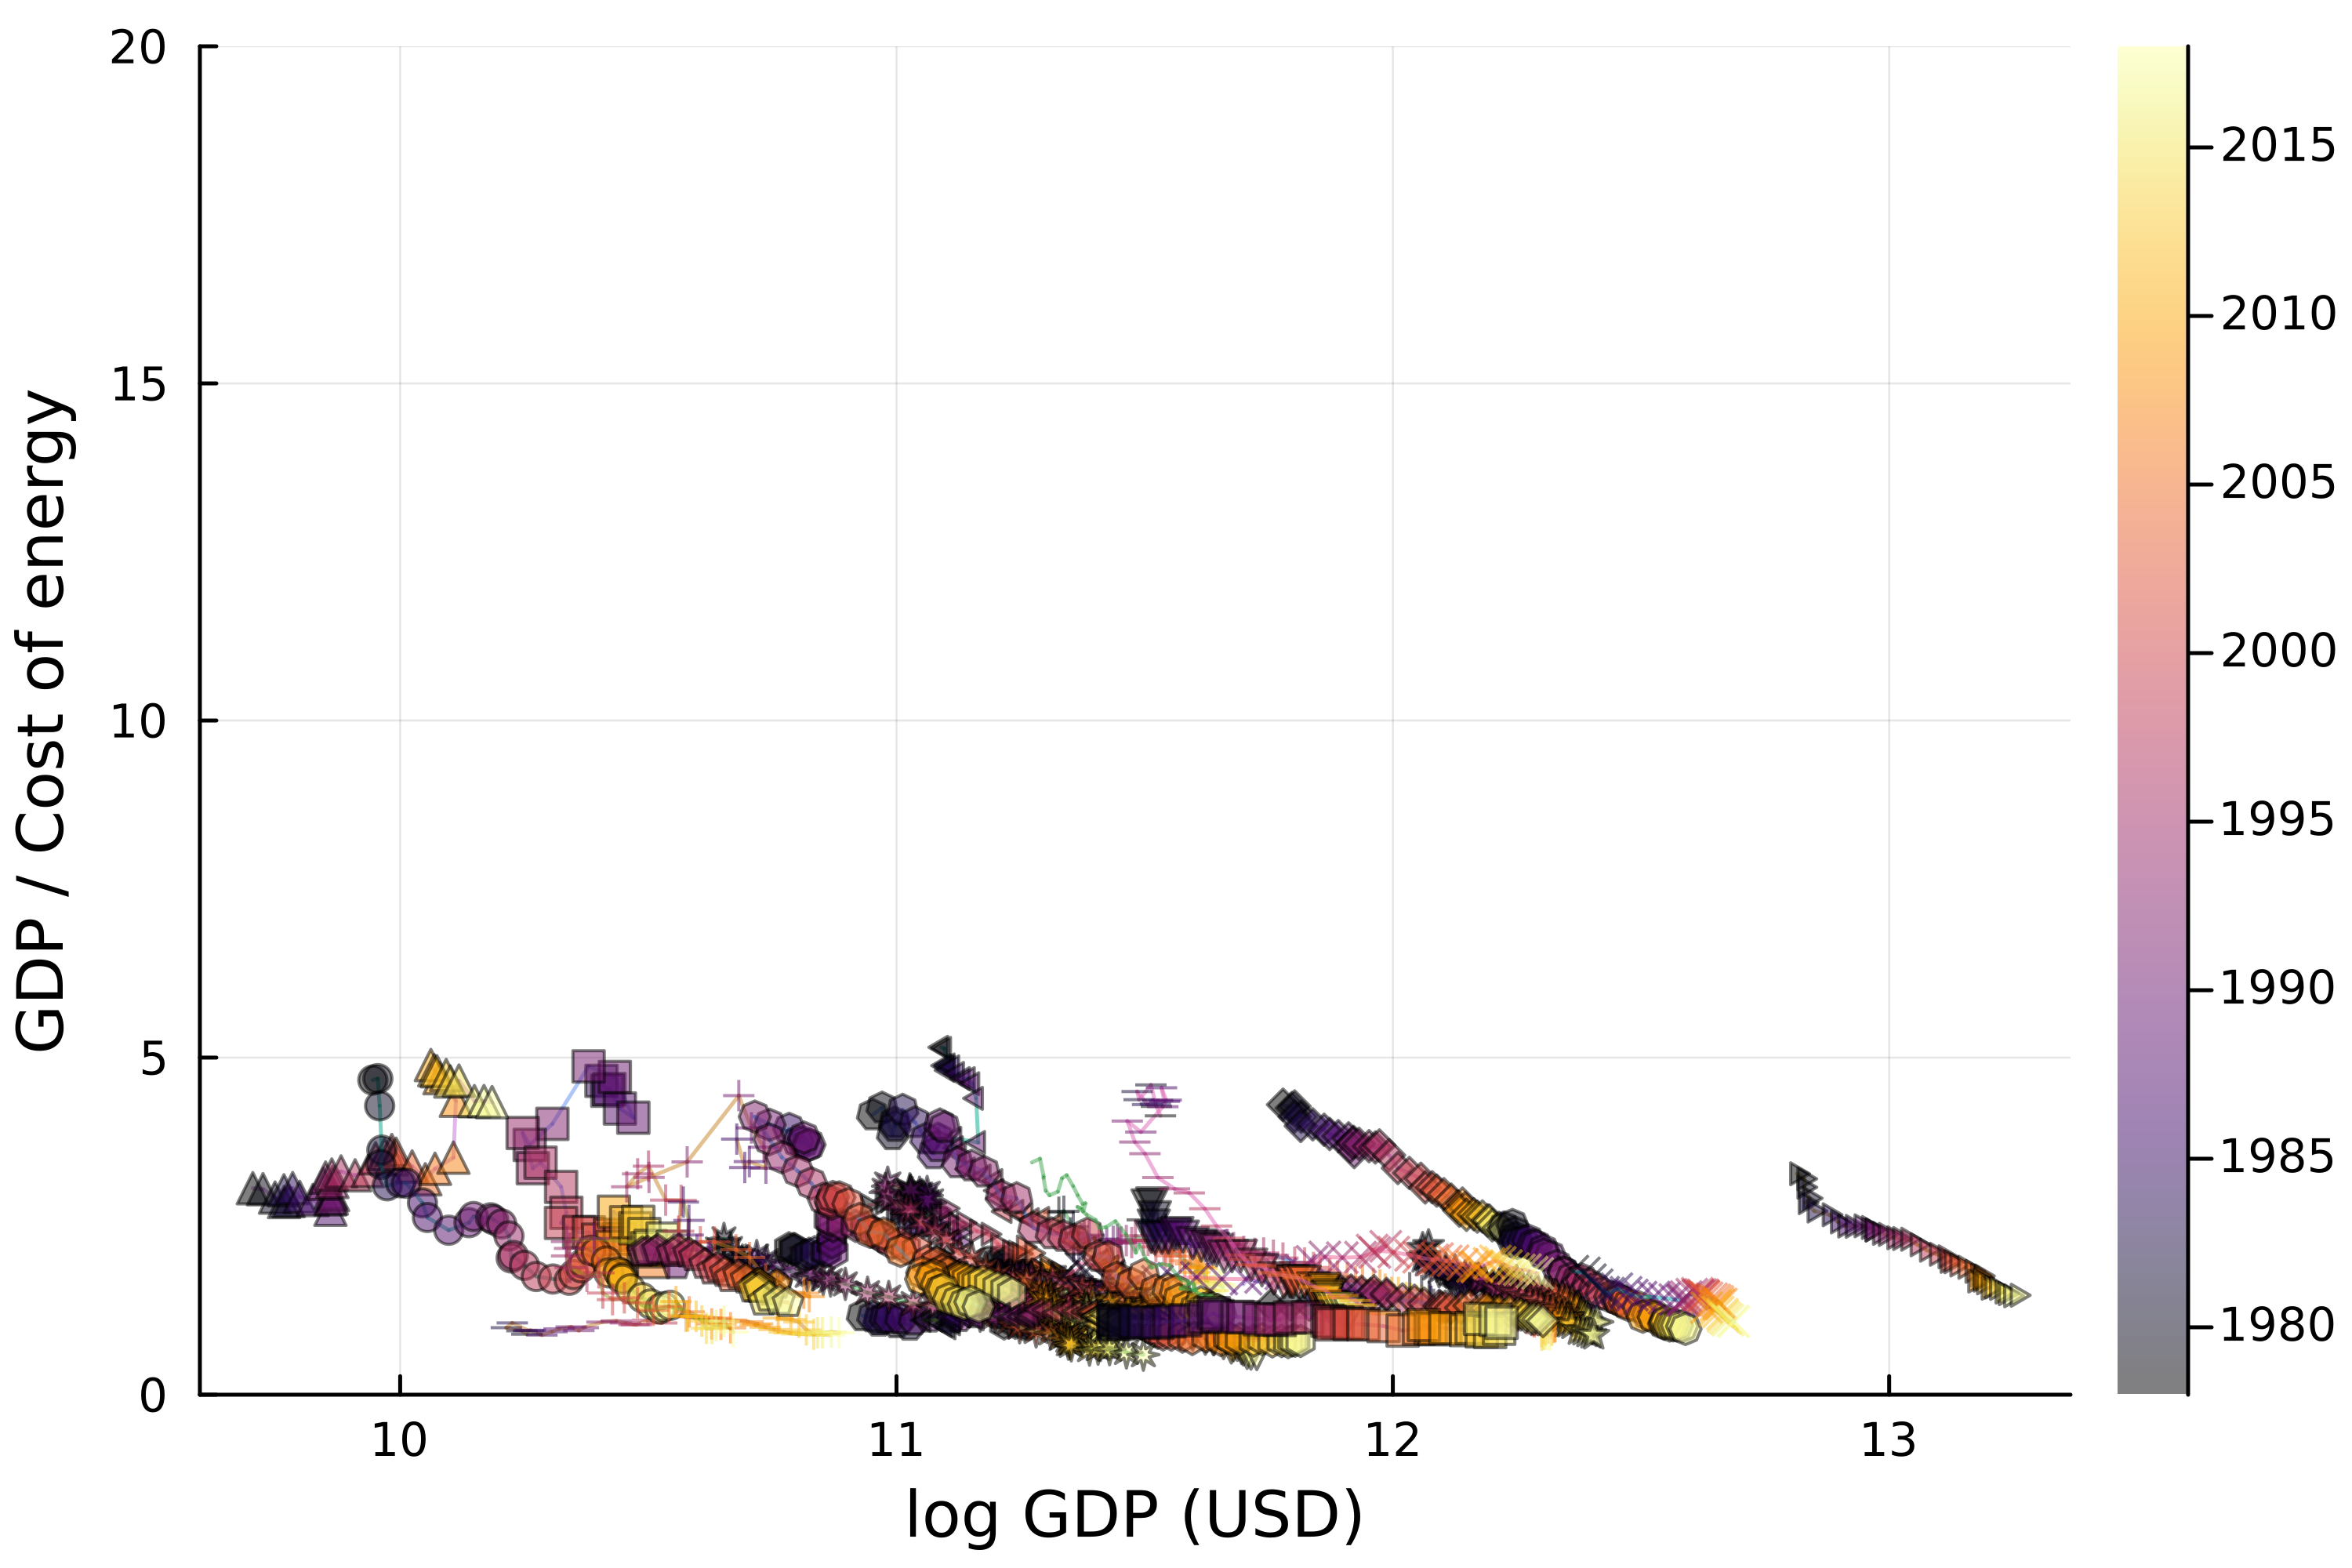

In [53]:
@df data plot(
    log10.(:gdp),
    :energy_per_gdp,
    group = :iso_code,
    label = false,
    markers = :auto,
    marker_z = :year,
    alpha = .5,
    ylims = (0, 20),
    ylabel = "GDP / Cost of energy",
    xlabel = "log GDP (USD)",
    )

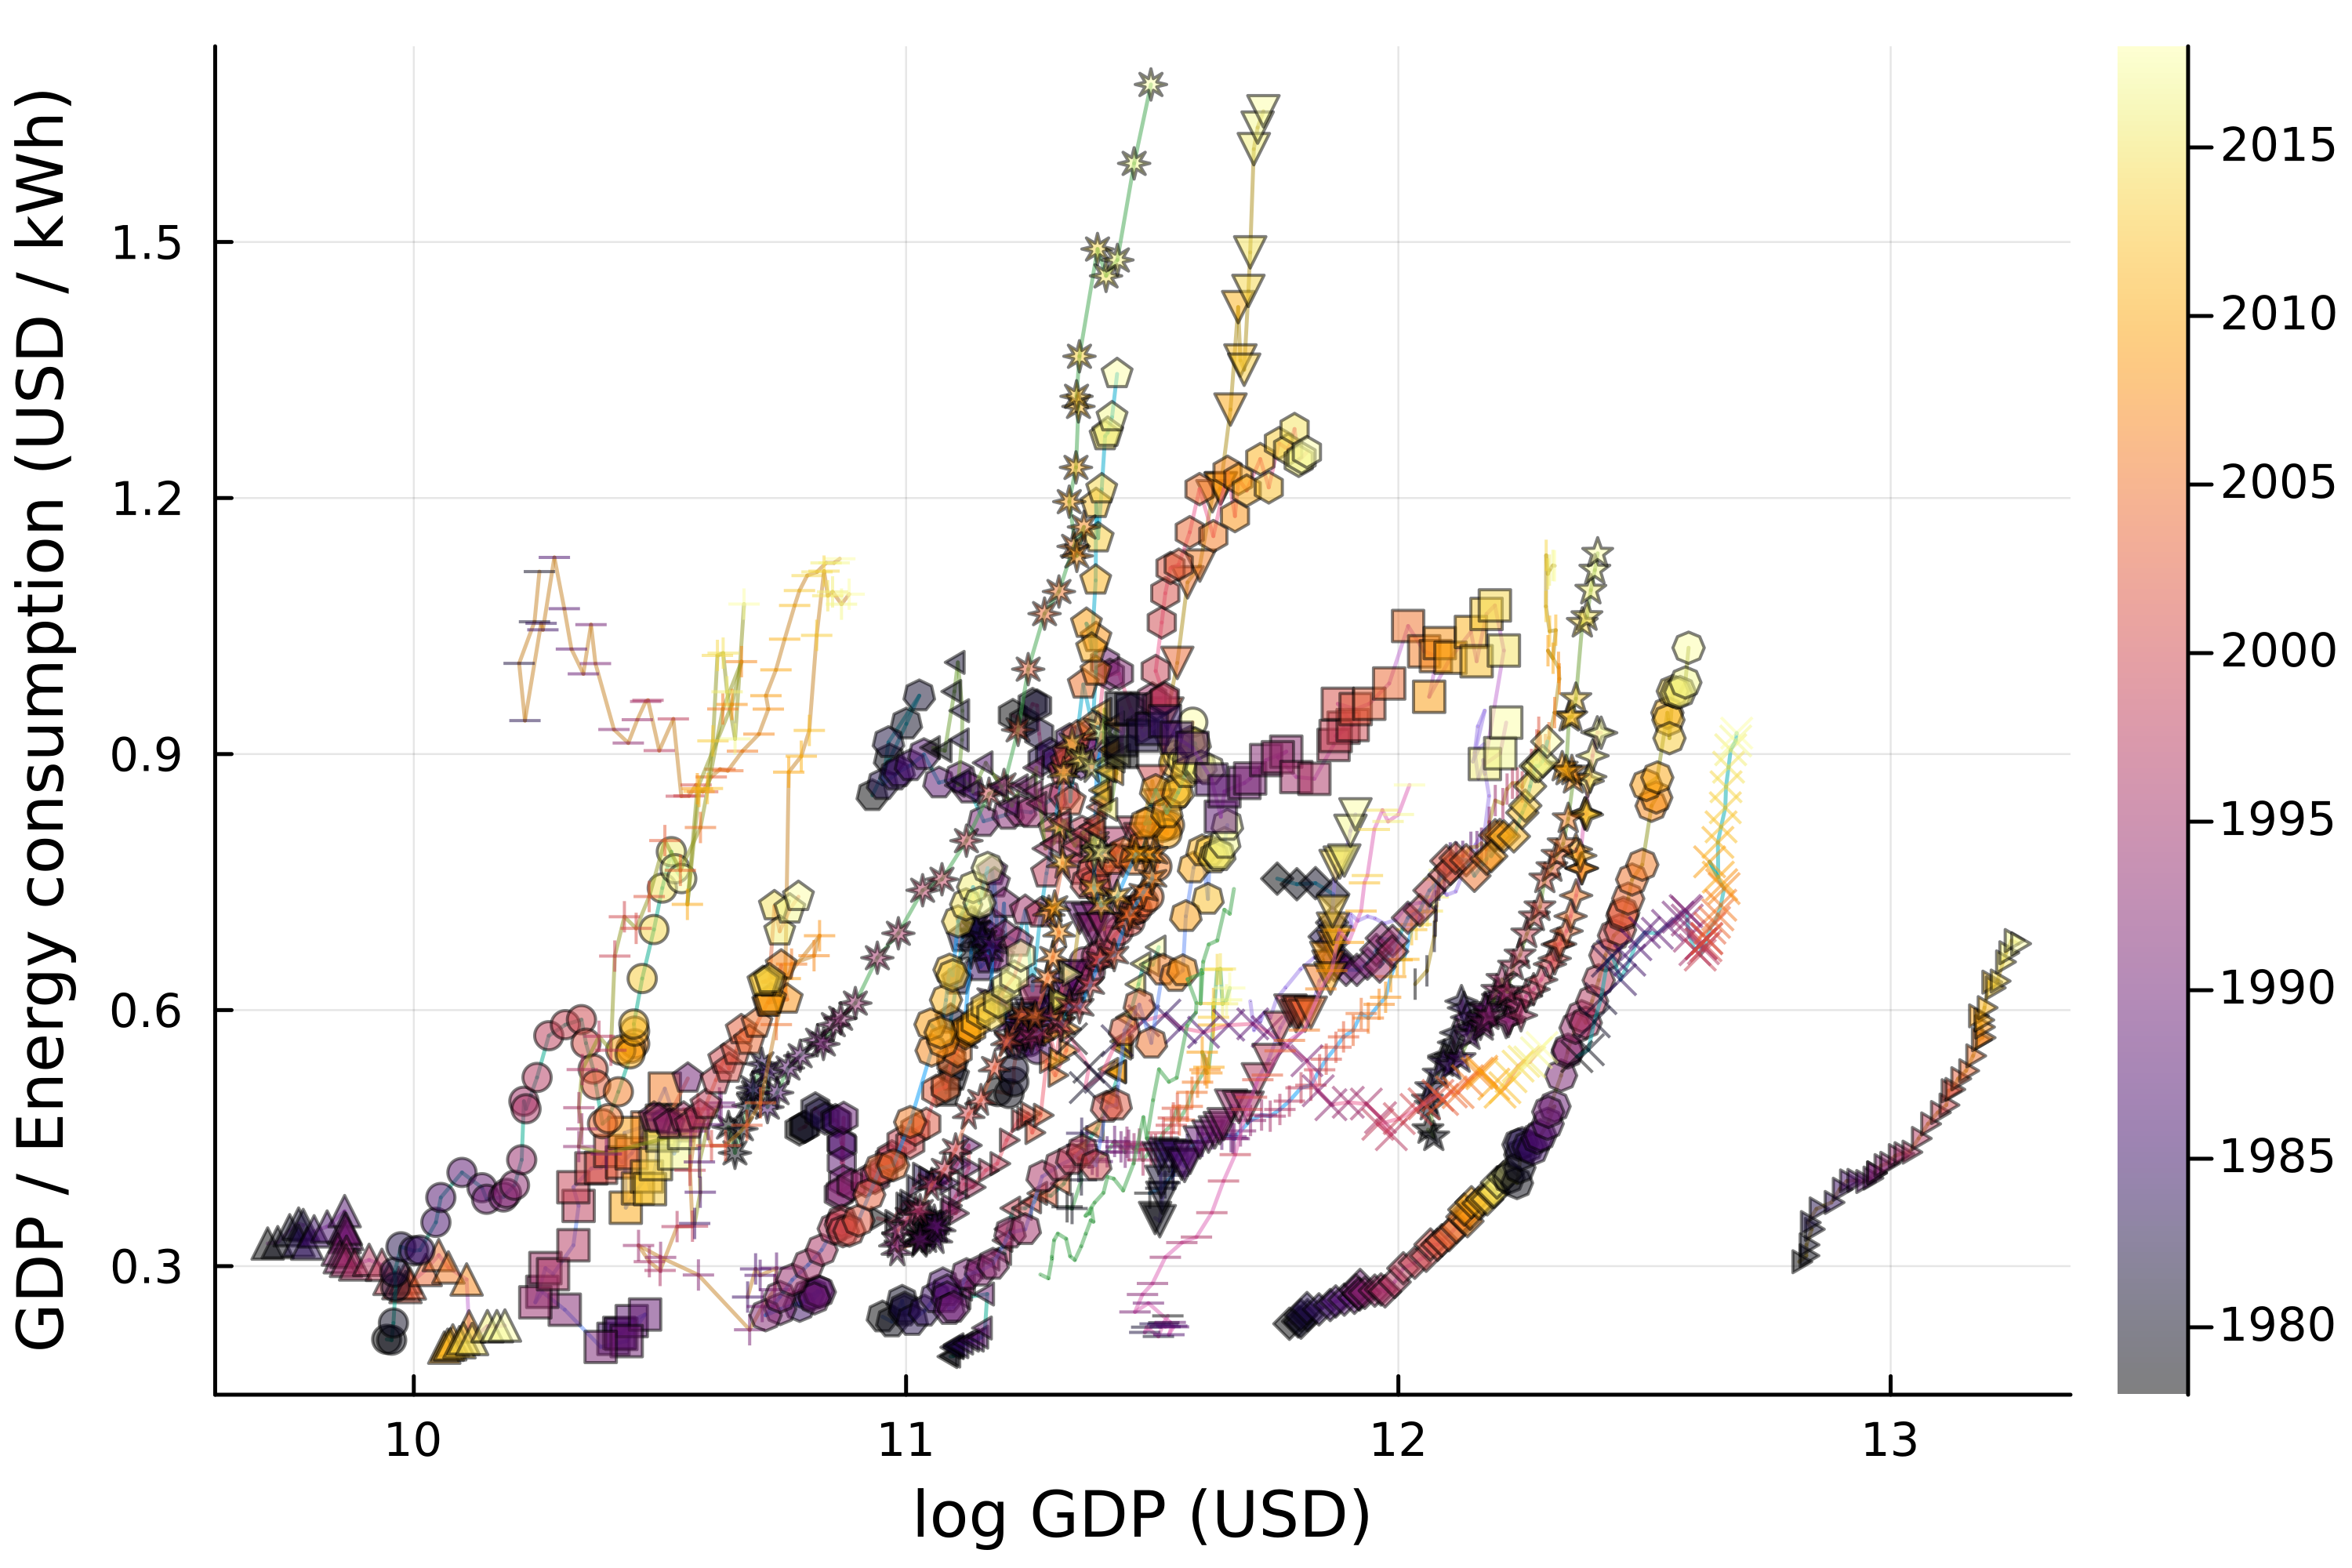

In [46]:
@df data plot(
    log10.(:gdp),
    :gdp ./ :energy,
    group = :iso_code,
    label = false,
    markers = :auto,
    marker_z = :year,
    alpha = .5,
    ylabel = "GDP / Energy consumption (USD / kWh)",
    xlabel = "log GDP (USD)",
    )